In [ ]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
data_dir = "data/"
num_workers = 4
batch_sz = 128
img_size = 64
num_channels = 3
latent_dim = 100
gen_feat = 64
disc_feat = 64
epochs = 50
learning_rate = 0.0002
adam_beta1 = 0.5
gpus = 1


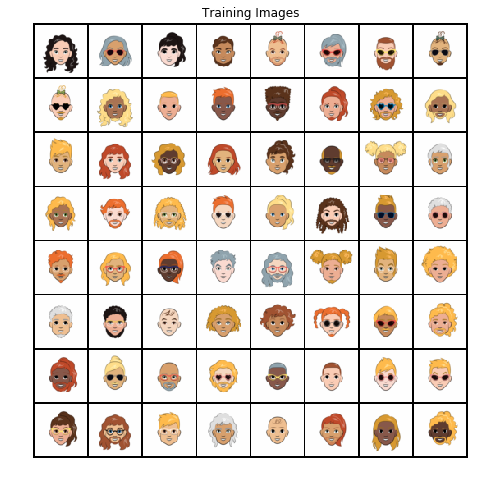

In [ ]:
dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz,
                                         shuffle=True, num_workers=num_workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and gpus > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))


In [ ]:
def weights_init(m):
    name = m.__class__.__name__
    if 'Conv' in name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in name:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
class Generator(nn.Module):
    def __init__(self, gpus):
        super(Generator, self).__init__()
        self.gpus = gpus
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feat * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat * 8, gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat * 4, gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat * 2, gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
gen = Generator(gpus).to(device)
gen.apply(weights_init)

print(gen)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, gpus):
        super(Discriminator, self).__init__()
        self.gpus = gpus
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, disc_feat, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feat, disc_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feat * 2, disc_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feat * 4, disc_feat * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(disc_feat * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
disc = Discriminator(gpus).to(device)
disc.apply(weights_init)

print(disc)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
loss_fn = nn.BCELoss()

fixed_z = torch.randn(64, latent_dim, 1, 1, device=device)

label_real = 1
label_fake = 0

opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))


In [ ]:
imgs = []
gen_losses = []
disc_losses = []
step = 0

print("Training...")

for epoch in range(epochs):
    for i, batch in enumerate(dataloader, 0):
        disc.zero_grad()
        real = batch[0].to(device)
        bs = real.size(0)
        label = torch.full((bs,), label_real, device=device)

        out_real = disc(real).view(-1)
        loss_real = loss_fn(out_real, label)
        loss_real.backward()
        d_x = out_real.mean().item()

        z = torch.randn(bs, latent_dim, 1, 1, device=device)
        fake = gen(z)
        label.fill_(label_fake)
        out_fake = disc(fake.detach()).view(-1)
        loss_fake = loss_fn(out_fake, label)
        loss_fake.backward()
        d_g_z1 = out_fake.mean().item()

        loss_disc = loss_real + loss_fake
        opt_disc.step()

        gen.zero_grad()
        label.fill_(label_real)
        out_fake = disc(fake).view(-1)
        loss_gen = loss_fn(out_fake, label)
        loss_gen.backward()
        d_g_z2 = out_fake.mean().item()
        opt_gen.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     loss_disc.item(), loss_gen.item(), d_x, d_g_z1, d_g_z2))

        gen_losses.append(loss_gen.item())
        disc_losses.append(loss_disc.item())

        if epoch % 10 == 0:
            torch.save(gen, "generator" + str(epoch))
            torch.save(disc, "discriminator" + str(epoch))

        if (step % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gen(fixed_z).detach().cpu()
            imgs.append(vutils.make_grid(fake, padding=2, normalize=True))

        step += 1


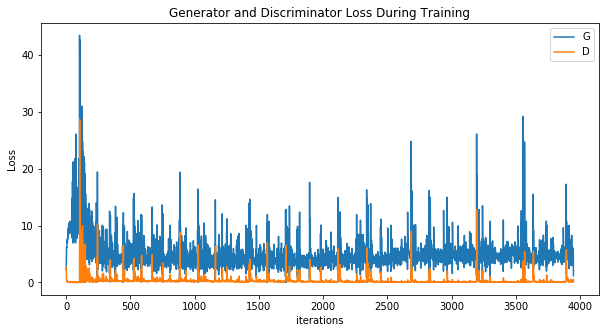

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


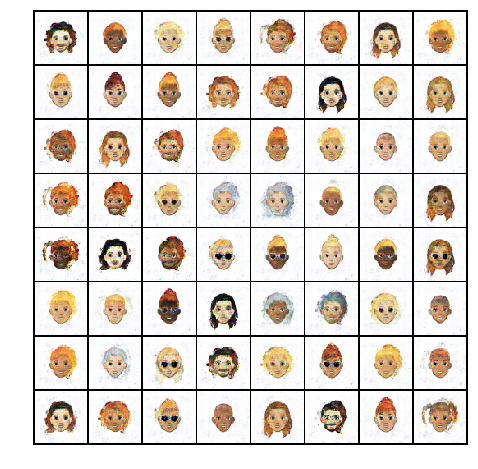

In [ ]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in imgs]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


In [17]:
from IPython.display import HTML, Image

In [18]:
ani.save('./animation.gif', writer='imagemagick', fps=60)
Image(url='./animation.gif', )

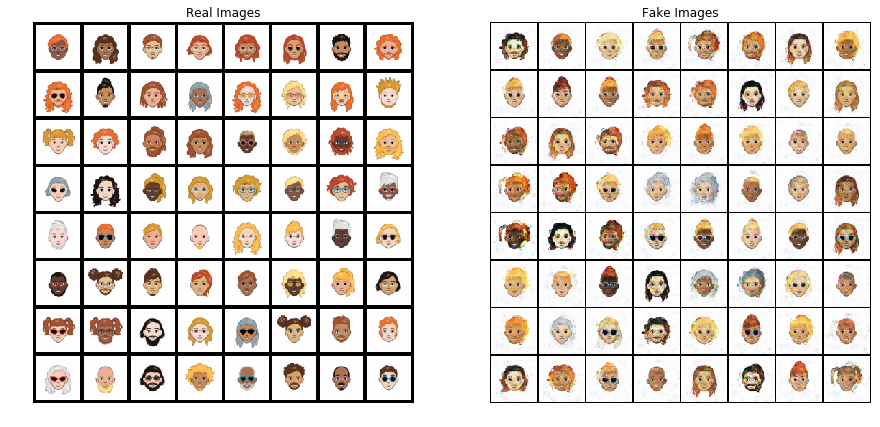

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgs[-1], (1, 2, 0)))
plt.show()


## Evaluation Code

In [ ]:
class Generator(nn.Module):
    def __init__(self, gpus):
        super(Generator, self).__init__()
        self.gpus = gpus
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feat * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat * 8, gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat * 4, gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat * 2, gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat),
            nn.ReLU(True),

            nn.ConvTranspose2d(gen_feat, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


In [7]:
netG = torch.load("generator49")
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpus > 0) else "cpu")
fixed_z = torch.randn(1, latent_dim, 1, 1, device=device)


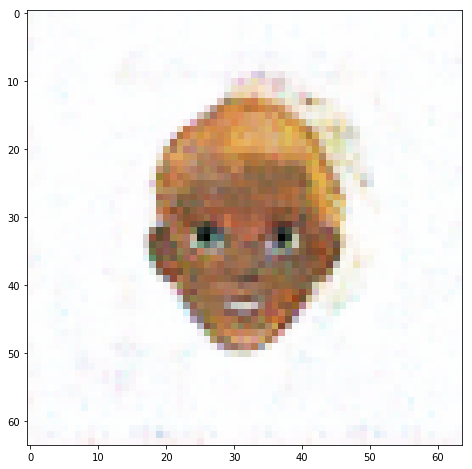

In [ ]:
plt.figure(figsize=(8, 8))
with torch.no_grad():
    fake = gen(fixed_z).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake[:64], padding=5, normalize=True), (1, 2, 0)))


In [ ]:
fixed_z2 = torch.randn(1, latent_dim, 1, 1, device=device)


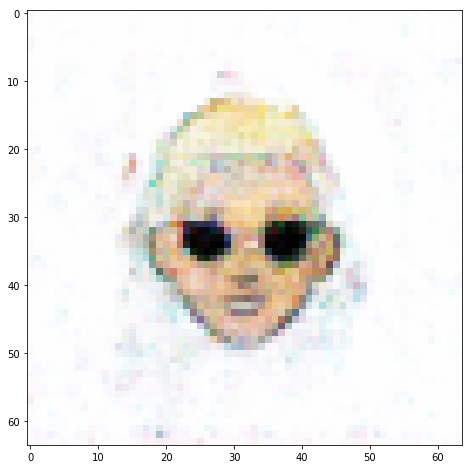

In [ ]:
plt.figure(figsize=(8, 8))
with torch.no_grad():
    fake = gen(fixed_z2).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake[:64], padding=5, normalize=True), (1, 2, 0)))


In [ ]:
fixed_z3 = torch.randn(1, latent_dim, 1, 1, device=device)


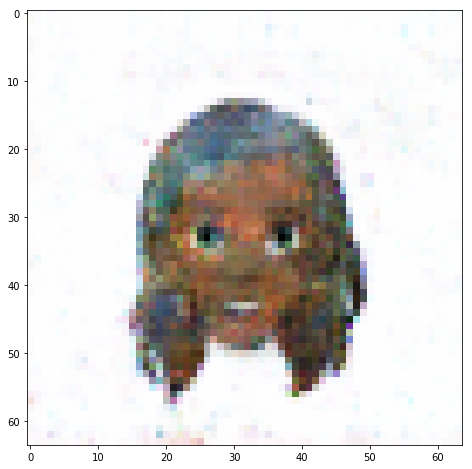

In [ ]:
plt.figure(figsize=(8, 8))
with torch.no_grad():
    fake = gen(fixed_z3).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake[:64], padding=5, normalize=True), (1, 2, 0)))


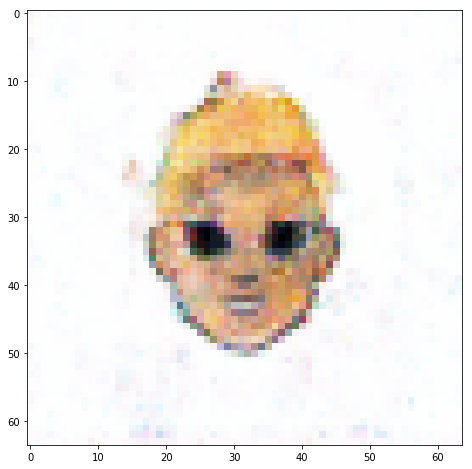

In [ ]:
plt.figure(figsize=(8, 8))
with torch.no_grad():
    z = fixed_z2 + fixed_z - fixed_z3
    fake = gen(z).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake[:64], padding=5, normalize=True), (1, 2, 0)))


In [ ]:
print(fixed_z)
print(fixed_z2)
print(fixed_z3)


tensor([[[[ 8.1949e-01]],

         [[ 1.7710e+00]],

         [[-4.2281e-01]],

         [[ 6.1404e-01]],

         [[-5.2538e-01]],

         [[ 4.6862e-01]],

         [[ 4.9997e-01]],

         [[-1.0183e+00]],

         [[-1.4407e+00]],

         [[-1.2683e+00]],

         [[-1.5438e-02]],

         [[-2.0843e+00]],

         [[-6.3859e-01]],

         [[-1.2843e+00]],

         [[-1.8637e+00]],

         [[-1.4454e+00]],

         [[ 1.7000e+00]],

         [[ 5.0845e-01]],

         [[-8.5999e-01]],

         [[ 1.3174e-01]],

         [[-4.6489e-01]],

         [[-9.3685e-01]],

         [[-1.7637e+00]],

         [[ 3.5038e-01]],

         [[ 4.0996e-01]],

         [[-9.9953e-01]],

         [[-2.2837e-01]],

         [[-5.5754e-01]],

         [[-8.8864e-01]],

         [[-8.1641e-01]],

         [[ 1.0960e+00]],

         [[ 1.6664e+00]],

         [[ 1.1433e+00]],

         [[-2.8756e-01]],

         [[ 7.0532e-01]],

         [[ 1.0693e+00]],

         [[ 8.3062e-01]],

 

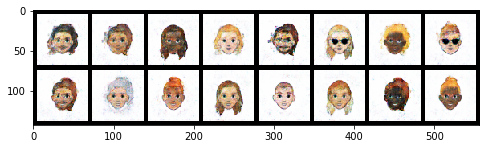

In [ ]:
fixed_z4 = torch.randn(16, latent_dim, 1, 1, device=device)

plt.figure(figsize=(8, 8))
with torch.no_grad():
    fake = gen(fixed_z4).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True), (1, 2, 0)))
